In [111]:
import pathlib
import os
import random
import copy
import re
from tqdm import tqdm, trange
from glob import glob

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import math

import scipy 
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import sklearn
import nibabel as nib
import imblearn
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [112]:
def get_file_path(root:str, label):
    paths = [x.replace('\\', '/') for x in glob(root, recursive=True)]
    result = []
    for i in paths:
        if 'Post' not in i:
            result.append(i)
    return [result, label]
g1_paths = get_file_path('G1/**/*.nii.gz',0)
g2_paths = get_file_path('G2/**/*.nii.gz',1)


In [113]:
def concatenate_and_fill(file_paths, slice_range, save_path):
    image = []
    for i in trange(0, int(len(file_paths[0])/3)):
        lbl = file_paths[1]
        t1,t2,flair = [], [], []

        t1 = nib.load(file_paths[0][i*3+1]).get_fdata().astype('float32').swapaxes(0,2)
        t2 = nib.load(file_paths[0][i*3+2]).get_fdata().astype('float32').swapaxes(0,2)
        flair = nib.load(file_paths[0][i*3]).get_fdata().astype('float32').swapaxes(0,2)

        t1 = min_max_normalize(t1[slice_range[0]:slice_range[1],np.newaxis, :,:])
        t2 = min_max_normalize(t2[slice_range[0]:slice_range[1],np.newaxis, :,:])
        flair = min_max_normalize(flair[slice_range[0]:slice_range[1],np.newaxis, :,:])
        concatenated_result = np.concatenate((t1,t2,flair),axis=1)
    #     print(concatenated_result.shape, t1.shape, t2.shape, flair.shape)
    #     print(np.min(concatenated_result), np.max(concatenated_result))
        for j in concatenated_result:
            image.append(j)

    print(np.array(image).shape)
    np.save(save_path+'_img.npy', image)


def min_max_normalize(input_array):
    for (subject_ind, subjects) in enumerate(input_array):
        for (slice_ind, slices) in enumerate(subjects):
            minimum = np.min(slices)
            maximum = np.max(slices)
            if maximum == minimum: 
                continue
            input_array[subject_ind][slice_ind] = (slices - minimum)/(maximum-minimum)
    return input_array

In [115]:
concatenate_and_fill(g1_paths,[40,140],'concatenated_data/g1_concatenated')
concatenate_and_fill(g2_paths,[40,140],'concatenated_data/g2_concatenated')

100%|██████████| 11/11 [00:03<00:00,  3.15it/s]


(1100, 3, 218, 182)


100%|██████████| 23/23 [00:07<00:00,  3.14it/s]


(2300, 3, 218, 182)


(182, 218, 182)


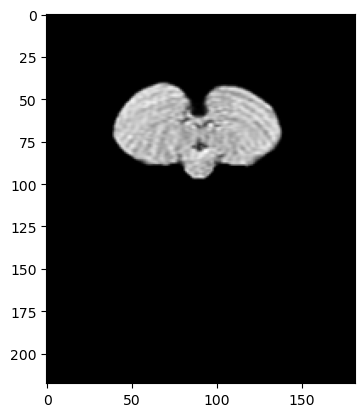

In [99]:
t1 = nib.load('G1/RR-044/FLAIR_MNI_reg.nii.gz').get_fdata().astype('float32').swapaxes(0,2)
print(t1.shape)

plt.imshow(t1[20][:][:], cmap="grey")
